# Sujet 1 : Concentration de CO2 dans l'atmosphère depuis 1958

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os.path
import pandas as pd
import datetime
import scipy.signal as sps
import scipy.optimize as spo

# Récupération des données

On va commencer par mettre les données dans un dataframe pandas. 

In [2]:
data_url = r'https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/weekly/weekly_in_situ_co2_mlo.csv'
data_file = r'weekly_in_situ_co2_mlo.csv'

if not os.path.exists(data_file):
    print('please downlad the csv file of the following url', data_url, '\n', 'and put it in the jupyter repository, at:', 
         'https://app-learninglab.inria.fr/moocrr/jupyter/user/your_unique_identifier/edit/work/module3/exo3/weekly_in_situ_co2_mlo.csv')
else: 
    data = pd.read_csv(data_file, skiprows=44, names=['week', 'CO2'])

J'ai eu des problèmes pour télécharger automatiquement les données (problème de certificat: cf [ce post sur StackOverflow](https://stackoverflow.com/questions/32400867/pandas-read-csv-from-url)), et puis ensuite pour y accéder depuis Jupyter. 
La solution la plus simple que j'ai trouvée est de télécharger à la main les données, puis de les réenvoyer dans le dossier Jupyter en ligne (cf [ce post](https://stackoverflow.com/questions/46972225/how-to-open-local-file-on-jupyter))

# Nettoyage et mise en forme des données

On visualise ensuite rapidement les données:

In [3]:
data.head()

week     CO2
0  1958-03-29  316.19
1  1958-04-05  317.31
2  1958-04-12  317.69
3  1958-04-19  317.58
4  1958-04-26  316.48

In [4]:
data.shape

(3229, 2)

On a deux colonnes et 3229 lignes (une par semaine). 

In [5]:
data.dtypes

week     object
CO2     float64
dtype: object

On voit que la première colonne est du type "objet", il nous faut le transformer en un format "date":

In [6]:
data['week'] = data['week'].astype('datetime64[ns]')

In [7]:
data.dtypes

week    datetime64[ns]
CO2            float64
dtype: object

On vérifie qu'il n'y a pas de données manquantes en regardant si les semaines se suivent bien.

In [8]:
for p1, p2 in zip(data['week'][:-1], data['week'][1:]):
    delta = p2-p1
    if delta > 7*pd.Timedelta('1day'):
        print(p1,p2)

1958-05-03 00:00:00 1958-05-17 00:00:00
1958-05-24 00:00:00 1958-07-05 00:00:00
1958-08-16 00:00:00 1958-08-30 00:00:00
1958-09-06 00:00:00 1958-11-08 00:00:00
1959-01-31 00:00:00 1959-02-14 00:00:00
1959-03-07 00:00:00 1959-03-21 00:00:00
1959-05-23 00:00:00 1959-06-06 00:00:00
1959-08-08 00:00:00 1959-08-22 00:00:00
1962-08-18 00:00:00 1962-09-15 00:00:00
1962-12-22 00:00:00 1963-01-05 00:00:00
1963-02-09 00:00:00 1963-02-23 00:00:00
1963-04-27 00:00:00 1963-05-11 00:00:00
1963-11-16 00:00:00 1963-11-30 00:00:00
1964-01-18 00:00:00 1964-05-30 00:00:00
1964-06-06 00:00:00 1964-06-27 00:00:00
1964-08-01 00:00:00 1964-08-15 00:00:00
1966-07-09 00:00:00 1966-08-06 00:00:00
1966-10-29 00:00:00 1966-11-12 00:00:00
1967-01-14 00:00:00 1967-02-04 00:00:00
1976-06-19 00:00:00 1976-07-03 00:00:00
1984-03-24 00:00:00 1984-04-28 00:00:00
1985-07-27 00:00:00 1985-08-10 00:00:00
2003-06-07 00:00:00 2003-06-21 00:00:00
2003-10-04 00:00:00 2003-10-25 00:00:00
2005-02-19 00:00:00 2005-03-26 00:00:00


On constate qu'il manque quelques données. Il faudra prendre cela en compte par la suite. Pour faciliter le traitement des données, on va temporairement indexer le dataframe avec la première colonne, celle des semaines. Puis on va remplir les lignes manquantes avec des 'NaN'. Cela facilitera grandement l'analyse de la période. 

In [9]:
data.set_index('week', inplace=True)

In [10]:
data = data.resample('W').sum()
data.replace(0, np.nan, inplace=True)

On vérifie à nouveau s'il manque des lignes: cette fois, on a des NaN à la place.

In [11]:
for p1, p2 in zip(data.index[:-1], data.index[1:]):
    delta = p2-p1
    if delta > 7*pd.Timedelta('1day'):
        print(p1,p2)

In [12]:
data

CO2
week              
1958-03-30  316.19
1958-04-06  317.31
1958-04-13  317.69
1958-04-20  317.58
1958-04-27  316.48
1958-05-04  316.95
1958-05-11     NaN
1958-05-18  317.56
1958-05-25  317.99
1958-06-01     NaN
1958-06-08     NaN
1958-06-15     NaN
1958-06-22     NaN
1958-06-29     NaN
1958-07-06  315.85
1958-07-13  315.85
1958-07-20  315.46
1958-07-27  315.59
1958-08-03  315.64
1958-08-10  315.10
1958-08-17  315.09
1958-08-24     NaN
1958-08-31  314.14
1958-09-07  313.54
1958-09-14     NaN
1958-09-21     NaN
1958-09-28     NaN
1958-10-05     NaN
1958-10-12     NaN
1958-10-19     NaN
...            ...
2020-12-06  413.00
2020-12-13  413.60
2020-12-20  414.34
2020-12-27  414.64
2021-01-03  415.19
2021-01-10  414.83
2021-01-17  414.84
2021-01-24  415.46
2021-01-31  415.68
2021-02-07  416.91
2021-02-14  416.46
2021-02-21  416.16
2021-02-28  416.43
2021-03-07  417.56
2021-03-14  416.54
2021-03-21  417.93
2021-03-28  416.43
2021-04-04  417.69
2021-04-11  419.02
2021-04-18  417.66
2021-04-25  418.54
2021-05-02  419.65
2021-05-09  418.16
2021-05-16  418.90
2021-05-23  417.94
2021-05-30  419.49
2021-06-06  419.54
2021-06-13  418.93
2021-06-20  418.49
2021-06-27  417.82

[3301 rows x 1 columns]

# Visualisation des données

On peut maintenant tracer le graphique. 

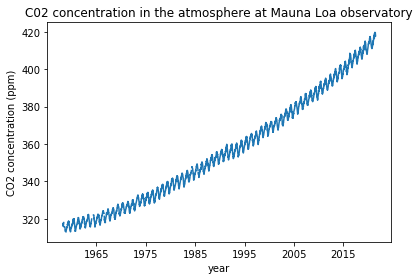

In [13]:
plt.plot(data['CO2'])
plt.title('C02 concentration in the atmosphere at Mauna Loa observatory')
plt.ylabel('CO2 concentration (ppm)')
plt.xlabel('year')
plt.tight_layout()

On va maintenant réaliser une moyenne glissante sur les données, sur 1 an, pour s'affranchir de la périodicité annuelle. On travaille directement avec le temps,(cf [la doc de pandas sur la fonction rolling](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html)).

In [14]:
data['CO2_smooth'] = data['CO2'].rolling('31536000s').mean()

On va maintenant superposer les deux jeux de données: 

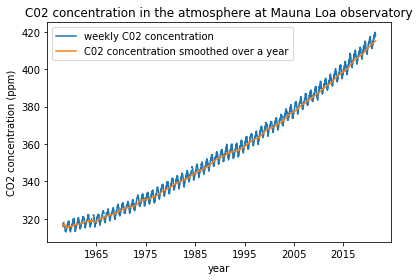

In [15]:
plt.plot(data['CO2'], label='weekly C02 concentration')
plt.plot(data['CO2_smooth'], label='C02 concentration smoothed over a year')
plt.title('C02 concentration in the atmosphere at Mauna Loa observatory')
plt.ylabel('CO2 concentration (ppm)')
plt.xlabel('year')
plt.legend()
plt.tight_layout()

# Etude de l'oscillation périodique


Pour faciliter le traitement de l'oscillation périodique, on repasse l'index en numérique plutôt qu'en temps. 

In [16]:
data = data.reset_index()

Pour caractériser l'oscillation périodique, on va soustraire à la concentration brute l'évolution de la concentration moyennée sur 1 an. Dans ce cas simple, il suffit de zoomer un peu sur la courbe pour voir que l'oscillation est annuelle. 
Mais pour aller un peu plus loin, essayons de mieux caractériser cette oscillation. Elle s'apparente à un signal triangle, de période 1 an, et d'amplitude 4ppm. On va donc superposer un tel signal, créé numériquement. On est obligés de le tracer en fonction d'un index recréé, car sawtooth ne peut pas gérer le format datetime. Mais puisque il ne manque pas de dates, on a une parfaite correspondance entre les deux. 

In [17]:
data['CO2-CO2_smooth'] = data['CO2'] - data['CO2_smooth']

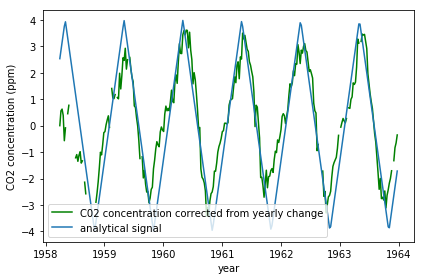

In [18]:
i, j = 0,300
plt.plot(data['week'][i:j], data['CO2-CO2_smooth'][i:j], label='C02 concentration corrected from yearly change', color='g')
plt.plot(data['week'][i:j],4*sps.sawtooth(2*np.pi*data.index*1/52.1429-10, width=0.5)[i:j], label='analytical signal')
plt.ylabel('CO2 concentration (ppm)')
plt.xlabel('year')
plt.legend()
plt.tight_layout()

En zoomant sur quelques endroits de la courbe avec i et j (entre 0 et 3301), on peut voir que ce signal triangle analytique se superpose bien aux données.Si on voulait être beaucoup plus précis, on pourrait faire de l'optimisation de ces paramètres pour que les deux signaux soient les plus proches possibles, mais je considère que cela n'apporterait pas beaucoup plus de précision. 

# Etude de la variation de la concentration en C02 à échelle anuelle
On va regarder l'évolution de la concentration en C02 corrigée de la variation saisonnière.

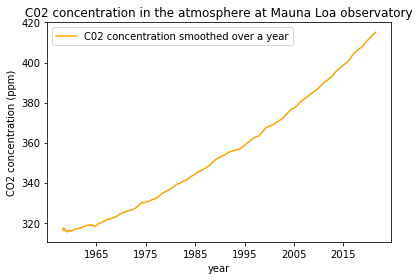

In [19]:
plt.plot(data['week'],data['CO2_smooth'], label='C02 concentration smoothed over a year', color='orange')
plt.title('C02 concentration in the atmosphere at Mauna Loa observatory')
plt.ylabel('CO2 concentration (ppm)')
plt.xlabel('year')
plt.legend()
plt.tight_layout()

On va essayer de fitter deux modèles sur l'évolution de la concentration en C02: un modèle linéaire et un modèle exponentiel. Pour cela, on utilise les fonctions d'optimisation de la bibliothèque scipy.optimize

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


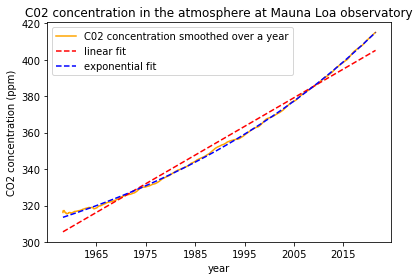

In [20]:
def func_linear(xdata, a, b):
    ydata = a*xdata+b
    return ydata

def func_exp(xdata, a, b, c):
    ydata = a * np.exp(-b * xdata) + c
    return ydata

xdata = data.index
ydata = data['CO2_smooth']
popt_linear, pcov_linear = spo.curve_fit(func_linear, xdata, ydata)
popt_exp, pcov_exp = spo.curve_fit(func_exp, xdata, ydata)


plt.plot(data['week'],data['CO2_smooth'], label='C02 concentration smoothed over a year', color='orange')
plt.plot(data['week'],func_linear(xdata, *popt_linear), '--', label='linear fit',  color='red')
plt.plot(data['week'],func_exp(xdata, *popt_exp), '--', label='exponential fit',  color='blue')

plt.title('C02 concentration in the atmosphere at Mauna Loa observatory')
plt.ylabel('CO2 concentration (ppm)')
plt.xlabel('year')
plt.legend()
plt.tight_layout()

Le modèle exponentiel correspond très bien. C'est logique: tous les ans, l'humanité émet plus de CO2 que l'année précédente, et cela s'accumule donc de plus en plus vite dans l'atmosphère. 

On peut facilement estimer la concentration en 2025 en étendant la prédiction:

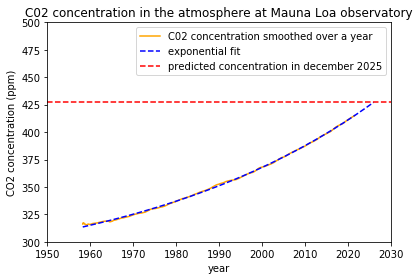

In [21]:
xdata_extended_dates = pd.date_range(start='1958-03-30', end='2025-12-01', dtype='datetime64[ns]', freq='W')
xdata_extended = np.arange(len(xdata_extended_dates))
plt.plot(data['week'],data['CO2_smooth'], label='C02 concentration smoothed over a year', color='orange')
plt.plot(xdata_extended_dates,func_exp(xdata_extended, *popt_exp), '--', label='exponential fit',  color='blue')
plt.axhline(y=func_exp(xdata_extended[-1], *popt_exp), label='predicted concentration in december 2025', linestyle='--', color='r')
plt.xlim(np.datetime64('1950-01-01'), np.datetime64('2030-01-01'))
plt.ylim(300,500)

plt.title('C02 concentration in the atmosphere at Mauna Loa observatory')
plt.ylabel('CO2 concentration (ppm)')
plt.xlabel('year')
plt.legend()
plt.tight_layout()

La concentration en C02 dans l'atmosphère devrait donc être, en décembre 2025, de:

In [22]:
print(int(func_exp(xdata_extended[-1], *popt_exp)), 'ppm')

427 ppm


PS: Ce qui a comme conséquence directe [ceci](https://www.francetvinfo.fr/monde/afrique/madagascar/madagascar-une-famine-causee-par-le-rechauffement-climatique_4683471.html).